In [0]:
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
transform_train = transforms.Compose([transforms.RandomAffine(degrees = 15, translate = (0.15, 0.15)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                    ])
transform_test = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, ))
                               ])

In [0]:
training_dataset = datasets.MNIST(root='./data', train = True, download = True, transform = transform_train)
validation_dataset = datasets.MNIST(root='./data', train = False, download = True, transform = transform_test)

In [0]:
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 64, shuffle = True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 64, shuffle = False)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

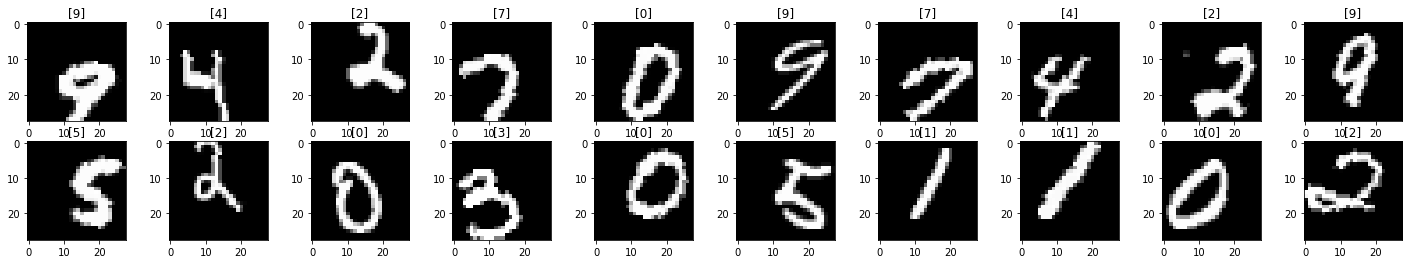

In [58]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
   

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 300)
    self.fc3 = nn.Linear(300, 100)
    self.fc4 = nn.Linear(100, 10)
    
  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*50)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x  
      

In [60]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [62]:
epochs = 14
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:    
    inputs = inputs.to(device) #GPU
    labels = labels.to(device) #GPU
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else: 
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device) #GPU
        val_labels = val_labels.to(device) #GPU
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_dataset)*100
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_dataset)*100
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch: ', (e+1))
    print('training loss: {:.4f}, {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch:  1
training loss: 0.5954, 80.3867 
validation loss: 0.1191, 96.0900 
epoch:  2
training loss: 0.1702, 94.6900 
validation loss: 0.0592, 98.0500 
epoch:  3
training loss: 0.1211, 96.2817 
validation loss: 0.0490, 98.3600 
epoch:  4
training loss: 0.0998, 96.8700 
validation loss: 0.0371, 98.7000 
epoch:  5
training loss: 0.0861, 97.3250 
validation loss: 0.0280, 99.0800 
epoch:  6
training loss: 0.0791, 97.5150 
validation loss: 0.0359, 98.9100 
epoch:  7
training loss: 0.0684, 97.8800 
validation loss: 0.0361, 98.8400 
epoch:  8
training loss: 0.0617, 98.0917 
validation loss: 0.0259, 99.1800 
epoch:  9
training loss: 0.0588, 98.1650 
validation loss: 0.0264, 99.0700 
epoch:  10
training loss: 0.0555, 98.2533 
validation loss: 0.0246, 99.1800 
epoch:  11
training loss: 0.0523, 98.3517 
validation loss: 0.0253, 99.1900 
epoch:  12
training loss: 0.0501, 98.4733 
validation loss: 0.0267, 99.1800 
epoch:  13
training loss: 0.0469, 98.5350 
validation loss: 0.0256, 99.2000 
epoch:  

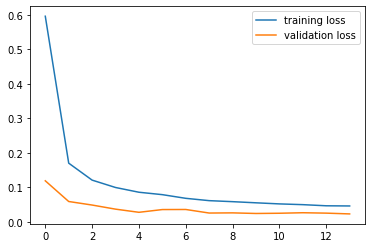

In [63]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

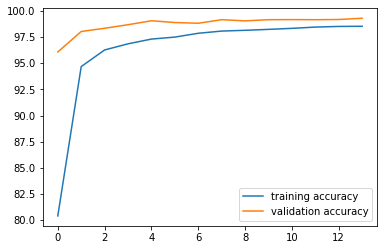

In [64]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()